In [1]:
import palaestrai as pal
from palaestrai.core import RuntimeConfig as PalRc
from palaestrai.store import Session
import palaestrai.store.database_model as paldb

In [2]:
import os
import sys
import pathlib
from datetime import datetime

In [3]:
import ipywidgets
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
import sqlparse
import sqlalchemy as sa
import sqlalchemy.dialects.postgresql
from sqlalchemy.sql.expression import func

In [5]:
import ruamel.yaml
YAML = ruamel.yaml.YAML(typ="safe")

In [6]:
NOTEBOOK_DIR = pathlib.Path(os.path.abspath(os.getcwd()))

In [7]:
EXPERIMENT_RUN_YML = YAML.load(
    NOTEBOOK_DIR
    / ".."
    / "palaestrai-runfiles"
    / "Classic-ARL-with-Timeseries_run-0.yml"
)
EXPERIMENT_RUN_YML

{'run_config': {'condition': {'name': 'palaestrai.experiment:VanillaRunGovernorTerminationCondition',
   'params': {}}},
 'schedule': [{'phaseI_attacker': {'agents': [{'actuators': ['midas_powergrid.Pysimmods-0.Photovoltaic-0.p_set_mw',
       'midas_powergrid.Pysimmods-0.Photovoltaic-0.q_set_mvar',
       'midas_powergrid.Pysimmods-0.Photovoltaic-2.p_set_mw',
       'midas_powergrid.Pysimmods-0.Photovoltaic-2.q_set_mvar',
       'midas_powergrid.Pysimmods-0.Photovoltaic-3.p_set_mw',
       'midas_powergrid.Pysimmods-0.Photovoltaic-3.q_set_mvar',
       'midas_powergrid.Pysimmods-0.Photovoltaic-6.p_set_mw',
       'midas_powergrid.Pysimmods-0.Photovoltaic-6.q_set_mvar',
       'midas_powergrid.Pysimmods-0.HVAC-0.p_set_mw',
       'midas_powergrid.Pysimmods-0.HVAC-1.p_set_mw',
       'midas_powergrid.Pysimmods-0.CHP-0.p_set_mw',
       'midas_powergrid.Pysimmods-0.CHP-1.p_set_mw',
       'midas_powergrid.Pysimmods-0.CHP-2.p_set_mw'],
      'brain': {'name': 'harl.ppo.brain:PPOBrain',
  

In [8]:
ENV_CONFIG = EXPERIMENT_RUN_YML["schedule"][0]["phaseI_attacker"]["environments"][0]
ENV_CONFIG

{'environment': {'name': 'palaestrai_mosaik:MosaikEnvironment',
  'params': {'arl_sync_freq': 300,
   'description_func': 'describe',
   'end': 1200001,
   'instance_func': 'get_world',
   'module': 'midas.tools.palaestrai:Descriptor',
   'params': {'config': 'midas-scenarios/classic-arl.yml',
    'end': 1200001,
    'mosaik_params': {'addr': ['127.0.0.1', 56781]},
    'name': 'carl_cigre_ts',
    'start_date': 'random',
    'step_size': 300,
    'store_params': {'buffer_size': 1000,
     'filename': 'carl_with_arl_ts.hdf5',
     'keep_old_files': True}},
   'silence_missing_input_connections_warning': True},
  'uid': 'midas_powergrid'},
 'reward': {'name': 'midas.tools.palaestrai.rewards:AllesDestroyAllPire2RewardIchWeissNicht',
  'params': {}}}

In [9]:
EXP_RUN_NAME = EXPERIMENT_RUN_YML["uid"]
STEPS = (int(ENV_CONFIG["environment"]["params"]["end"]) - 1) // int(
    ENV_CONFIG["environment"]["params"]["arl_sync_freq"]
)
NPHASES = len(EXPERIMENT_RUN_YML["schedule"])
PHASES = []
for phase in EXPERIMENT_RUN_YML["schedule"]:
    for pname in phase:
        PHASES.append(pname)
EID = f'{datetime.today().strftime("%Y%m%d")}-{EXPERIMENT_RUN_YML["uid"].lower().replace(" ", "-")}-v1'

PLOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "results", EID))
success = False
while not success:
    try:
        os.makedirs(PLOT_PATH, exist_ok=False)
        success = True
    except OSError:
        prev = int(EID[-1])
        EID = f"{EID[:-1]}{prev+1}"
        PLOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "results", EID))

AGENTS = []
for acfg in EXPERIMENT_RUN_YML["schedule"][2]["phaseIII_att_def"]["agents"]:
    atype = "defender" if "andalf" in acfg["name"] else "attacker"
    AGENTS.append(
        {
            "name": acfg["name"],
            "brain": acfg["brain"]["name"].split(":")[-1],
            "goal": atype,
            "objective": acfg["objective"]["name"].split(":")[-1]
        }
    )

In [10]:
META_DATA = (
    f"# {EXP_RUN_NAME}\n\n"
    f"* {STEPS} simulation steps for each phase\n"
    f"* {NPHASES} Phases\n"
)
for phase in PHASES:
    META_DATA += f"  * {phase}\n"
for agent in AGENTS:
    META_DATA += (
        f"* {agent['brain']} {agent['goal']}\n"
        f"  * name={agent['name']}\n"
        f"  * objective={agent['objective']}\n"
    )

META_DATA += (
    "\n# Experiment Run Dump\n\n"
    f"{EXPERIMENT_RUN_YML}"
)
REWARD_VOLTAGE = os.path.join(PLOT_PATH, "reward_voltage.png")
REWARD_LOADING = os.path.join(PLOT_PATH, "reward_loading.png")
REWARD_ERIKA = os.path.join(PLOT_PATH, "reward_erika_reward.png")

with open(os.path.join(PLOT_PATH, "metadata.md"), "w") as f:
    f.write(META_DATA)
    f.write("\n\n*Created at ")
    f.write(datetime.now().strftime("%H:%M:%S%z, %Y-%m-%d"))
    f.write("*\n")

STORE_URI = f"sqlite:///{os.path.abspath(os.path.join(os.getcwd(), '..', 'palaestrai.db'))}"

ERI_IDX = -1

In [11]:
PalRc().reset()
PalRc().load({"store_uri": STORE_URI})

In [12]:
dbh = Session()

In [13]:
q = (
    sa.select(
        paldb.ExperimentRun, 
        paldb.ExperimentRunInstance
    )
    .join(
        paldb.ExperimentRun.experiment_run_instances
    )
    .where(
        paldb.ExperimentRun.uid == EXP_RUN_NAME
    )
    .order_by(paldb.ExperimentRunInstance.id.desc())
)
eris = dbh.execute(q).all()


In [14]:
eri_selector = ipywidgets.Dropdown(
    description="Experiment Run Instance",
    options=[
        (
            f"{row[paldb.ExperimentRunInstance].id}. {row[paldb.ExperimentRunInstance].created_at}", row[paldb.ExperimentRunInstance].id
        )
        for row in eris
    ],
    style={"description": "initial"}
)
eri_selector

Dropdown(description='Experiment Run Instance', options=(('16. 2022-09-20 13:47:28', 16), ('15. 2022-09-20 13:…

In [15]:
eri_id = eri_selector.value
eri_id

16

In [16]:
q = (
    sa.select(
        paldb.ExperimentRunPhase
    )
    .join(
        paldb.ExperimentRunPhase.experiment_run_instance
    )
    .where(
        paldb.ExperimentRunInstance.id == eri_id
    )
    .order_by(
        paldb.ExperimentRunPhase.id.asc()
    )
)
result = dbh.execute(q).all()
phases = {
    row[paldb.ExperimentRunPhase].uid: row[paldb.ExperimentRunPhase].id
    for row in result
}
phases

{'phaseI_attacker': 37,
 'phaseII_defender': 38,
 'phaseIII_att_def': 39,
 'phaseIV_test_att_def': 40}

In [17]:
result

[(<palaestrai.store.database_model.ExperimentRunPhase object at 0x7f778af7f280>,),
 (<palaestrai.store.database_model.ExperimentRunPhase object at 0x7f778af7f2e0>,),
 (<palaestrai.store.database_model.ExperimentRunPhase object at 0x7f778af7f340>,),
 (<palaestrai.store.database_model.ExperimentRunPhase object at 0x7f778af7f3a0>,)]

In [18]:
q = sa.select(paldb.ExperimentRun).where(paldb.ExperimentRun.uid == EXP_RUN_NAME)
result = dbh.execute(q).one()
experiment_run_record = result[paldb.ExperimentRun]
experiment_run_record.id, experiment_run_record.uid

(2, 'Classic-ARL-with-Timeseries-0')

In [19]:
experiment_run_record.experiment_run_instances

In [20]:
eri_id = experiment_run_record.experiment_run_instances[ERI_IDX].id
experiment_run_record.experiment_run_instances[ERI_IDX].experiment_run_phases

In [21]:
run_phase_ids = [phase.id for phase in experiment_run_record.experiment_run_instances[ERI_IDX].experiment_run_phases]
run_phase_ids

[37, 38, 39, 40]

In [22]:
rewards = pd.read_sql(
    sa.select(paldb.MuscleAction, paldb.ExperimentRunPhase.uid.label("phase"), paldb.Agent.name)
    .join(paldb.MuscleAction.agent)
    .join(paldb.Agent.experiment_run_phase)
    .where(paldb.ExperimentRunPhase.experiment_run_instance_id == eri_id)
    .order_by(paldb.ExperimentRunPhase.id, paldb.MuscleAction.id),
    dbh.bind
)
rewards

id                   walltime  agent_id  \
0      39988 2022-09-20 13:47:42.047716        51   
1      39989 2022-09-20 13:47:45.652498        51   
2      39990 2022-09-20 13:47:45.901831        51   
3      39991 2022-09-20 13:47:46.218430        51   
4      39992 2022-09-20 13:47:46.655209        51   
...      ...                        ...       ...   
23995  63983 2022-09-20 15:53:21.511972        56   
23996  63984 2022-09-20 15:53:22.030048        55   
23997  63985 2022-09-20 15:53:22.082269        56   
23998  63986 2022-09-20 15:53:22.523043        55   
23999  63987 2022-09-20 15:53:22.594695        56   

                                                simtimes  \
0      {'midas_powergrid': {'py/object': 'palaestrai....   
1      {'midas_powergrid': {'py/object': 'palaestrai....   
2      {'midas_powergrid': {'py/object': 'palaestrai....   
3      {'midas_powergrid': {'py/object': 'palaestrai....   
4      {'midas_powergrid': {'py/object': 'palaestrai....   
...                                                  ...   
23995  {'midas_powergrid': {'py/object': 'palaestrai....   
23996  {'midas_powergrid': {'py/object': 'palaestrai....   
23997  {'midas_powergrid': {'py/object': 'palaestrai....   
23998  {'midas_powergrid': {'py/object': 'palaestrai....   
23999  {'midas_powergrid': {'py/object': 'palaestrai....   

                                         sensor_readings  \
0      [{'py/object': 'palaestrai.agent.sensor_inform...   
1      [{'py/object': 'palaestrai.agent.sensor_inform...   
2      [{'py/object': 'palaestrai.agent.sensor_inform...   
3      [{'py/object': 'palaestrai.agent.sensor_inform...   
4      [{'py/object': 'palaestrai.agent.sensor_inform...   
...                                                  ...   
23995  [{'py/object': 'palaestrai.agent.sensor_inform...   
23996  [{'py/object': 'palaestrai.agent.sensor_inform...   
23997  [{'py/object': 'palaestrai.agent.sensor_inform...   
23998  [{'py/object': 'palaestrai.agent.sensor_inform...   
23999  [{'py/object': 'palaestrai.agent.sensor_inform...   

                                      actuator_setpoints  \
0      [{'py/object': 'palaestrai.agent.actuator_info...   
1      [{'py/object': 'palaestrai.agent.actuator_info...   
2      [{'py/object': 'palaestrai.agent.actuator_info...   
3      [{'py/object': 'palaestrai.agent.actuator_info...   
4      [{'py/object': 'palaestrai.agent.actuator_info...   
...                                                  ...   
23995  [{'py/object': 'palaestrai.agent.actuator_info...   
23996  [{'py/object': 'palaestrai.agent.actuator_info...   
23997  [{'py/object': 'palaestrai.agent.actuator_info...   
23998  [{'py/object': 'palaestrai.agent.actuator_info...   
23999  [{'py/object': 'palaestrai.agent.actuator_info...   

                                                 rewards  \
0      [{'py/object': 'palaestrai.agent.reward_inform...   
1      [{'py/object': 'palaestrai.agent.reward_inform...   
2      [{'py/object': 'palaestrai.agent.reward_inform...   
3      [{'py/object': 'palaestrai.agent.reward_inform...   
4      [{'py/object': 'palaestrai.agent.reward_inform...   
...                                                  ...   
23995  [{'py/object': 'palaestrai.agent.reward_inform...   
23996  [{'py/object': 'palaestrai.agent.reward_inform...   
23997  [{'py/object': 'palaestrai.agent.reward_inform...   
23998  [{'py/object': 'palaestrai.agent.reward_inform...   
23999  [{'py/object': 'palaestrai.agent.reward_inform...   

                      phase     name  
0           phaseI_attacker   Sauron  
1           phaseI_attacker   Sauron  
2           phaseI_attacker   Sauron  
3           phaseI_attacker   Sauron  
4           phaseI_attacker   Sauron  
...                     ...      ...  
23995  phaseIV_test_att_def  Gandalf  
23996  phaseIV_test_att_def   Sauron  
23997  phaseIV_test_att_def  Gandalf  
23998  phaseIV_test_att_def   Sauron  
23999  phaseIV_test_att_def  Gandalf  

[24000 rows x 9 colu

In [23]:
def unpack_reward(x, i):
    if not x:
        print("Cell is empty!")
        return 0
    try:
        val = x[i]["reward_value"]["value"]
    except KeyError as err:
        try:
            val = x[i]["reward_value"]["values"][0]
        except KeyError as err:
            print(f"Error at index {i}: {err}")
            print(x[i])
            raise err
    except TypeError as err:
        return int(x[i]["reward_value"])
    except IndexError as err:
        print(i)
        print(x)
        print(x[i])
        print(x[i]["reward_value"])
        
    return float(val) if x else 0.0

cols = ["vm_pu_min", "vm_pu_max", "vm_pu_median", "vm_pu_mean", "vm_pu_std", "line_min", "line_max", "line_median", "line_mean", "line_std", "ErikaReward"]

for idx, name in enumerate(cols):
    print(idx, name)
    rewards[name] = rewards.rewards.apply(lambda x: unpack_reward(x, idx))
    # a_actions[name] = a_actions.rewards.apply(lambda x: unpack_reward(x, idx))

rewards




0 vm_pu_min
1 vm_pu_max
2 vm_pu_median
3 vm_pu_mean
4 vm_pu_std
5 line_min
6 line_max
7 line_median
8 line_mean
9 line_std
10 ErikaReward


id                   walltime  agent_id  \
0      39988 2022-09-20 13:47:42.047716        51   
1      39989 2022-09-20 13:47:45.652498        51   
2      39990 2022-09-20 13:47:45.901831        51   
3      39991 2022-09-20 13:47:46.218430        51   
4      39992 2022-09-20 13:47:46.655209        51   
...      ...                        ...       ...   
23995  63983 2022-09-20 15:53:21.511972        56   
23996  63984 2022-09-20 15:53:22.030048        55   
23997  63985 2022-09-20 15:53:22.082269        56   
23998  63986 2022-09-20 15:53:22.523043        55   
23999  63987 2022-09-20 15:53:22.594695        56   

                                                simtimes  \
0      {'midas_powergrid': {'py/object': 'palaestrai....   
1      {'midas_powergrid': {'py/object': 'palaestrai....   
2      {'midas_powergrid': {'py/object': 'palaestrai....   
3      {'midas_powergrid': {'py/object': 'palaestrai....   
4      {'midas_powergrid': {'py/object': 'palaestrai....   
...                                                  ...   
23995  {'midas_powergrid': {'py/object': 'palaestrai....   
23996  {'midas_powergrid': {'py/object': 'palaestrai....   
23997  {'midas_powergrid': {'py/object': 'palaestrai....   
23998  {'midas_powergrid': {'py/object': 'palaestrai....   
23999  {'midas_powergrid': {'py/object': 'palaestrai....   

                                         sensor_readings  \
0      [{'py/object': 'palaestrai.agent.sensor_inform...   
1      [{'py/object': 'palaestrai.agent.sensor_inform...   
2      [{'py/object': 'palaestrai.agent.sensor_inform...   
3      [{'py/object': 'palaestrai.agent.sensor_inform...   
4      [{'py/object': 'palaestrai.agent.sensor_inform...   
...                                                  ...   
23995  [{'py/object': 'palaestrai.agent.sensor_inform...   
23996  [{'py/object': 'palaestrai.agent.sensor_inform...   
23997  [{'py/object': 'palaestrai.agent.sensor_inform...   
23998  [{'py/object': 'palaestrai.agent.sensor_inform...   
23999  [{'py/object': 'palaestrai.agent.sensor_inform...   

                                      actuator_setpoints  \
0      [{'py/object': 'palaestrai.agent.actuator_info...   
1      [{'py/object': 'palaestrai.agent.actuator_info...   
2      [{'py/object': 'palaestrai.agent.actuator_info...   
3      [{'py/object': 'palaestrai.agent.actuator_info...   
4      [{'py/object': 'palaestrai.agent.actuator_info...   
...                                                  ...   
23995  [{'py/object': 'palaestrai.agent.actuator_info...   
23996  [{'py/object': 'palaestrai.agent.actuator_info...   
23997  [{'py/object': 'palaestrai.agent.actuator_info...   
23998  [{'py/object': 'palaestrai.agent.actuator_info...   
23999  [{'py/object': 'palaestrai.agent.actuator_info...   

                                                 rewards  \
0      [{'py/object': 'palaestrai.agent.reward_inform...   
1      [{'py/object': 'palaestrai.agent.reward_inform...   
2      [{'py/object': 'palaestrai.agent.reward_inform...   
3      [{'py/object': 'palaestrai.agent.reward_inform...   
4      [{'py/object': 'palaestrai.agent.reward_inform...   
...                                                  ...   
23995  [{'py/object': 'palaestrai.agent.reward_inform...   
23996  [{'py/object': 'palaestrai.agent.reward_inform...   
23997  [{'py/object': 'palaestrai.agent.reward_inform...   
23998  [{'py/object': 'palaestrai.agent.reward_inform...   
23999  [{'py/object': 'palaestrai.agent.reward_inform...   

                      phase     name  vm_pu_min  vm_pu_max  vm_pu_median  \
0           phaseI_attacker   Sauron   1.007545   1.031736      1.030310   
1           phaseI_attacker   Sauron   1.005050   1.029270      1.008587   
2           phaseI_attacker   Sauron   1.012868   1.030128      1.026362   
3           phaseI_attacker   Sauron   1.011121   1.058343      1.057142   
4           phaseI_attacker   Sauron   1.006503   1.039493      1.038163   
...                     ...      

In [24]:
unique_rewards = rewards.drop(
    rewards.loc[(rewards.phase.str.contains("phaseIII_att_def") | rewards.phase.str.contains("phaseIV_test_att_def")) & rewards.name.str.contains("Sauron")].index
)
unique_rewards
old_rewards = rewards
rewards = unique_rewards

In [25]:
rm = 2

rewards["vm_pu_min_mean"] = rewards["vm_pu_min"].rolling(rm).mean()
rewards["vm_pu_max_mean"] = rewards["vm_pu_max"].rolling(rm).mean()
rewards["vm_pu_mean_mean"] = rewards["vm_pu_mean"].rolling(rm).mean()
rewards["vm_pu_median_mean"] = rewards["vm_pu_median"].rolling(rm).mean()
rewards["line_min_mean"] = rewards["line_min"].rolling(rm).mean()
rewards["line_max_mean"] = rewards["line_max"].rolling(rm).mean()
rewards["line_median_mean"] = rewards["line_median"].rolling(rm).mean()
rewards["line_mean_mean"] = rewards["line_mean"].rolling(rm).mean()
rewards["ErikaReward_mean"] = rewards["ErikaReward"].rolling(rm).mean()
rewards

id                   walltime  agent_id  \
0      39988 2022-09-20 13:47:42.047716        51   
1      39989 2022-09-20 13:47:45.652498        51   
2      39990 2022-09-20 13:47:45.901831        51   
3      39991 2022-09-20 13:47:46.218430        51   
4      39992 2022-09-20 13:47:46.655209        51   
...      ...                        ...       ...   
23991  63979 2022-09-20 15:53:20.303524        56   
23993  63981 2022-09-20 15:53:21.008229        56   
23995  63983 2022-09-20 15:53:21.511972        56   
23997  63985 2022-09-20 15:53:22.082269        56   
23999  63987 2022-09-20 15:53:22.594695        56   

                                                simtimes  \
0      {'midas_powergrid': {'py/object': 'palaestrai....   
1      {'midas_powergrid': {'py/object': 'palaestrai....   
2      {'midas_powergrid': {'py/object': 'palaestrai....   
3      {'midas_powergrid': {'py/object': 'palaestrai....   
4      {'midas_powergrid': {'py/object': 'palaestrai....   
...                                                  ...   
23991  {'midas_powergrid': {'py/object': 'palaestrai....   
23993  {'midas_powergrid': {'py/object': 'palaestrai....   
23995  {'midas_powergrid': {'py/object': 'palaestrai....   
23997  {'midas_powergrid': {'py/object': 'palaestrai....   
23999  {'midas_powergrid': {'py/object': 'palaestrai....   

                                         sensor_readings  \
0      [{'py/object': 'palaestrai.agent.sensor_inform...   
1      [{'py/object': 'palaestrai.agent.sensor_inform...   
2      [{'py/object': 'palaestrai.agent.sensor_inform...   
3      [{'py/object': 'palaestrai.agent.sensor_inform...   
4      [{'py/object': 'palaestrai.agent.sensor_inform...   
...                                                  ...   
23991  [{'py/object': 'palaestrai.agent.sensor_inform...   
23993  [{'py/object': 'palaestrai.agent.sensor_inform...   
23995  [{'py/object': 'palaestrai.agent.sensor_inform...   
23997  [{'py/object': 'palaestrai.agent.sensor_inform...   
23999  [{'py/object': 'palaestrai.agent.sensor_inform...   

                                      actuator_setpoints  \
0      [{'py/object': 'palaestrai.agent.actuator_info...   
1      [{'py/object': 'palaestrai.agent.actuator_info...   
2      [{'py/object': 'palaestrai.agent.actuator_info...   
3      [{'py/object': 'palaestrai.agent.actuator_info...   
4      [{'py/object': 'palaestrai.agent.actuator_info...   
...                                                  ...   
23991  [{'py/object': 'palaestrai.agent.actuator_info...   
23993  [{'py/object': 'palaestrai.agent.actuator_info...   
23995  [{'py/object': 'palaestrai.agent.actuator_info...   
23997  [{'py/object': 'palaestrai.agent.actuator_info...   
23999  [{'py/object': 'palaestrai.agent.actuator_info...   

                                                 rewards  \
0      [{'py/object': 'palaestrai.agent.reward_inform...   
1      [{'py/object': 'palaestrai.agent.reward_inform...   
2      [{'py/object': 'palaestrai.agent.reward_inform...   
3      [{'py/object': 'palaestrai.agent.reward_inform...   
4      [{'py/object': 'palaestrai.agent.reward_inform...   
...                                                  ...   
23991  [{'py/object': 'palaestrai.agent.reward_inform...   
23993  [{'py/object': 'palaestrai.agent.reward_inform...   
23995  [{'py/object': 'palaestrai.agent.reward_inform...   
23997  [{'py/object': 'palaestrai.agent.reward_inform...   
23999  [{'py/object': 'palaestrai.agent.reward_inform...   

                      phase     name  vm_pu_min  ...  ErikaReward  \
0           phaseI_attacker   Sauron   1.007545  ...           72   
1           phaseI_attacker   Sauron   1.005050  ...           72   
2           phaseI_attacker   Sauron   1.012868  ...           72   
3           phaseI_attacker   Sauron   1.011121  ...          -27   
4           phaseI_attacker   Sauron   1.006503  ...           72   
...                     ...      ...        ...  ...          ...   
23991 

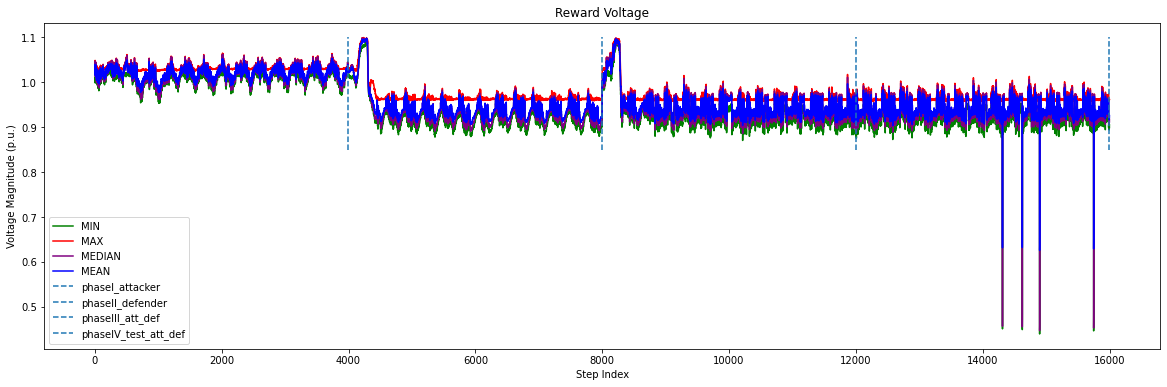

In [26]:
index = np.arange(len(rewards.index))
plt.figure(figsize=(20, 6))
plt.plot(index, rewards.vm_pu_min_mean, color="green", label="MIN")
plt.plot(index, rewards.vm_pu_max_mean, color="red", label="MAX")
plt.plot(index, rewards.vm_pu_median_mean, color="purple", label="MEDIAN")
plt.plot(index, rewards.vm_pu_mean_mean, color="blue", label="MEAN")
plt.vlines(STEPS - 0.5, ymin=0.85, ymax=1.1, label="phaseI_attacker", linestyles="dashed")
plt.vlines(STEPS*2 - 0.5, ymin=0.85, ymax=1.1, label="phaseII_defender", linestyles="dashed")
plt.vlines(STEPS*3 - 0.5, ymin=0.85, ymax=1.1, label="phaseIII_att_def", linestyles="dashed")
plt.vlines(STEPS*4 - 0.5, ymin=0.85, ymax=1.1, label="phaseIV_test_att_def", linestyles="dashed")
plt.xlabel("Step Index")
plt.ylabel("Voltage Magnitude (p.u.)")
plt.title("Reward Voltage")
plt.legend()

plt.savefig(REWARD_VOLTAGE, dpi=300, bbox_inches="tight")


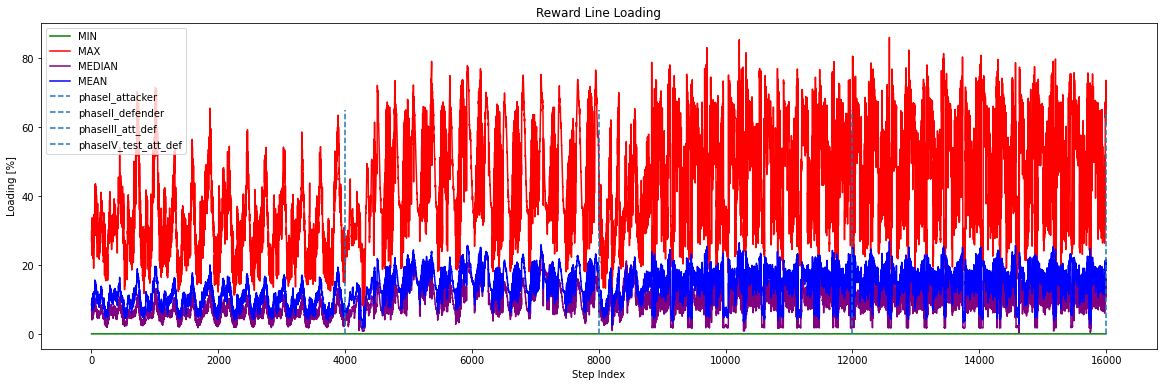

In [27]:
plt.figure(figsize=(20, 6))
plt.plot(index, rewards.line_min_mean, color="green", label="MIN")
plt.plot(index, rewards.line_max_mean, color="red", label="MAX")
plt.plot(index, rewards.line_median_mean, color="purple", label="MEDIAN")
plt.plot(index, rewards.line_mean_mean, color="blue", label="MEAN")
plt.vlines(STEPS - 0.5, ymin=0.0, ymax=65, label="phaseI_attacker", linestyles="dashed")
plt.vlines(STEPS*2 - 0.5, ymin=0.0, ymax=65, label="phaseII_defender", linestyles="dashed")
plt.vlines(STEPS*3 - 0.5, ymin=0.0, ymax=65, label="phaseIII_att_def", linestyles="dashed")
plt.vlines(STEPS*4 - 0.5, ymin=0.0, ymax=65, label="phaseIV_test_att_def", linestyles="dashed")
plt.xlabel("Step Index")
plt.ylabel("Loading [%]")
plt.title("Reward Line Loading")
plt.legend()

plt.savefig(REWARD_LOADING, dpi=300, bbox_inches="tight")

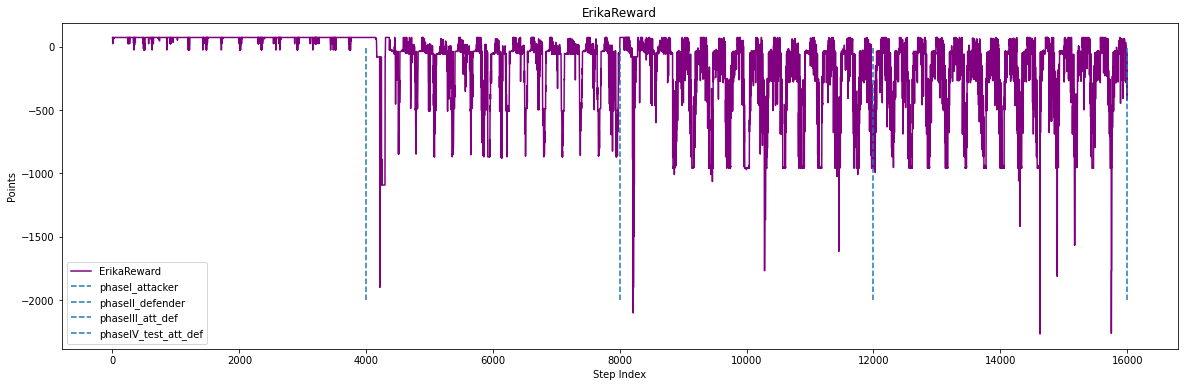

In [28]:
plt.figure(figsize=(20, 6))

plt.plot(index, rewards.ErikaReward_mean, color="purple", label="ErikaReward")
plt.vlines(STEPS - 0.5, ymin=-2000, ymax=0, label="phaseI_attacker", linestyles="dashed")
plt.vlines(STEPS*2 - 0.5, ymin=-2000, ymax=0, label="phaseII_defender", linestyles="dashed")
plt.vlines(STEPS*3 - 0.5, ymin=-2000, ymax=0, label="phaseIII_att_def", linestyles="dashed")
plt.vlines(STEPS*4 - 0.5, ymin=-2000, ymax=0, label="phaseIV_test_att_def", linestyles="dashed")
plt.xlabel("Step Index")
plt.ylabel("Points")
plt.title("ErikaReward")
plt.legend()
plt.savefig(REWARD_ERIKA, dpi=300, bbox_inches="tight")